## Análisis del reclutamiento por campaña

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import calendar

In [3]:
# Cargo las columnas que necesito
datos = pd.read_csv('/home/lautaro/Desktop/events.csv',
                    usecols = lambda col: col in ["event", "timestamp", "new_vs_returning", "campaign_source", "person"])

In [4]:
# Filtro los eventos que me interesan
visitas = datos.loc[datos["event"] == "visited site",["timestamp", "new_vs_returning", "person"]]
campania = datos.loc[datos["event"] == "ad campaign hit",["timestamp", "campaign_source", "person"]]

In [5]:
visitas = visitas.rename(index=str, columns = {"timestamp" : "hora visita"})
campania = campania.rename(index=str, columns = {"timestamp" : "hora campania"})

In [6]:
# Obtengo las visitas de usuarios nuevos
visitas = visitas.loc[visitas["new_vs_returning"] == "New",["hora visita", "person"]]

In [7]:
# Me quedo con la primer fecha de acceso a la pagina de cada usuario ya que el resto de las veces seria un "Returning"
campania = campania.groupby("person", as_index=False).min()

In [8]:
# Matcheamos la hora de la primer visita del usuario al sitio con la hora de su primer click en campaña
visitas_por_campania = visitas.merge(campania, how="inner", left_on="person", right_on="person")
visitas_por_campania = visitas_por_campania.drop(columns="person")

In [9]:
# Convierto las columnas de fechas a datetime para poder operar
visitas_por_campania["hora visita"] = pd.to_datetime(visitas_por_campania["hora visita"])
visitas_por_campania["hora campania"] = pd.to_datetime(visitas_por_campania["hora campania"])

In [10]:
# Para contabilizarlo como nuevo debido a la campaña la diferencia de tiempo entre los eventos debe ser poca
# Establezco un límite de 5 segundos de diferencia máxima
visitas_por_campania = visitas_por_campania.loc[((visitas_por_campania["hora visita"] - visitas_por_campania["hora campania"]) < pd.Timedelta("0 days 00:00:05")) & 
                                               ((visitas_por_campania["hora visita"] - visitas_por_campania["hora campania"]) > pd.Timedelta("-1 days +23:59:55")), :]

In [11]:
visitas_por_campania = visitas_por_campania.drop(columns="hora visita")
visitas_por_campania["cantidad"] = 1

In [43]:
# Puedo analizar como aportan las campañas mes a mes
campania_por_mes = visitas_por_campania
campania_por_mes["mes"] = campania_por_mes["hora campania"].dt.month
campania_por_mes = campania_por_mes.drop(columns="hora campania")

In [44]:
campania_por_mes = campania_por_mes.groupby(["campaign_source", "mes"], as_index=False).sum()
campania_por_mes = campania_por_mes.sort_values(by="cantidad", ascending=False)

In [45]:
print campania_por_mes.head(20)

   campaign_source  mes  cantidad
64          google    5      6400
65          google    6      5613
49          criteo    5      1787
50          criteo    6      1312
63          google    4       594
62          google    3       360
48          criteo    4       307
47          criteo    3       215
16     FacebookAds    6       169
61          google    2       162
60          google    1       147
46          criteo    2       101
36            bing    5        86
58          emblue    5        84
45          criteo    1        83
30          afilio    5        79
15     FacebookAds    5        78
76        rtbhouse    5        53
83           zanox    5        51
13     FacebookAds    3        47


Podemos observar que Google en el mes de mayo es el que más nuevos usuarios nos trajo, también vemos que en otros meses los valores no son tan altos por lo que sería interesante verlo en un gráfico.

In [47]:
google_por_mes = campania_por_mes.loc[campania_por_mes["campaign_source"] == "google",:]

Text(0,0.5,'Cantidad de usuarios')

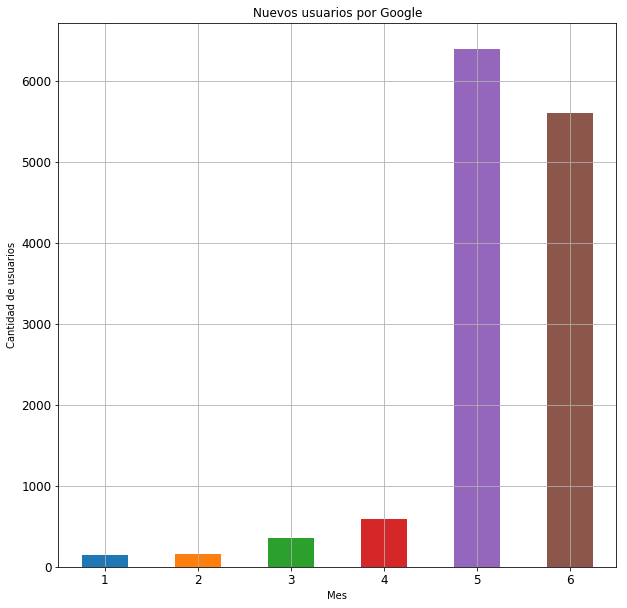

In [52]:
google_por_mes.sort_values(by="mes").plot(rot=0, kind="bar", x="mes", y="cantidad", figsize=(10,10), legend=False, fontsize=12, grid=True)

plt.title("Nuevos usuarios por Google")
plt.xlabel("Mes")
plt.ylabel("Cantidad de usuarios")

Podemos observar que en mayo la cantidad de nuevos usuarios que trajo Google aumentó muchísimo, para este gráfico también hay que tener en cuenta que los datos de junio son parciales (solo tenemos la mitad de junio cargada)

Otro gráfico que nos resulta interesante es ver el aporte de cada campaña en el mes de mayo. Elegimos el mes de mayo ya que es el último mes que fue cargado completamente.

In [53]:
mayo = campania_por_mes.loc[campania_por_mes["mes"] == 5,:]

In [54]:
print mayo

   campaign_source  mes  cantidad
64          google    5      6400
49          criteo    5      1787
36            bing    5        86
58          emblue    5        84
30          afilio    5        79
15     FacebookAds    5        78
76        rtbhouse    5        53
83           zanox    5        51
9         Facebook    5        18
24        afiliado    5         9
71     mercadopago    5         6
53       datacrush    5         5
73         rakuten    5         3
78           voxus    5         1
4              inf    5         1
80           yotpo    5         1
69        manifest    5         1
40            blog    5         1
67          indexa    5         1
19  FacebookSocial    5         1


Podemos observar a simple vista que la diferencia de usuarios nuevos que obtenemos por Google y Criteo es gigantesca.

Text(0,0.5,'Campania')

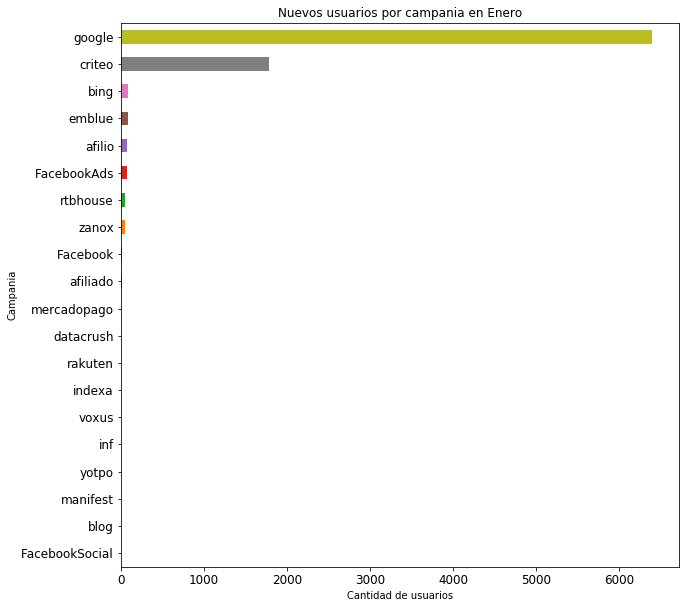

In [56]:
mayo.sort_values(by="cantidad").plot(rot=0, kind="barh", x="campaign_source", y="cantidad", figsize=(10,10), legend=False, fontsize=12)

plt.title("Nuevos usuarios por campania en Enero")
plt.xlabel("Cantidad de usuarios")
plt.ylabel("Campania")

Basados en estos resultados Trocafone podría, por ejemplo, dejar de abonar por publicidad en las peores campañas.

Por último podriamos observar cómo es el histórico de usuarios nuevos por campaña.

In [67]:
campanias_historico = campania_por_mes.drop(columns={"mes"})
campanias_historico = campanias_historico.groupby("campaign_source", as_index=False).sum().sort_values(by="cantidad", ascending=False)

In [68]:
print campanias_historico.head(20)

   campaign_source  cantidad
14          google     13276
11          criteo      3805
2      FacebookAds       355
7           afilio       196
13          emblue       178
8             bing       169
19        rtbhouse       103
22           zanox        88
10         buscape        38
1         Facebook        36
6         afiliado        18
0              inf        16
17     mercadopago        12
12       datacrush        10
18         rakuten         9
9             blog         6
15          indexa         4
3   FacebookSocial         4
20           voxus         3
16        manifest         2


Se mantiene la tendencia que observamos en el mes de mayo, las campañas más provechosas en usuarios son las de Google y Criteo